# NEU502a (Spring 2018)
## Problem Set #5: Reinforcement Learning

In [1]:
import h5py, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
from scipy.io import loadmat
from scipy.optimize import minimize
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def inv_logit(arr):
    '''Elementwise inverse logit (logistic) function.'''
    return 1 / (1 + np.exp(-arr))

def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal. 
    For details, see Bowling et al. (2009). "A logistic approximation 
    to the cumulative normal distribution."'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

def softmax(arr, beta=1):
    '''Softmax function'''
    return np.exp(beta * arr) / np.nansum( np.exp( beta * arr ) )

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Part 1: The Two-Step Task
In the following exercises, we will be analyzing behavior from the two-step task [(Daw et al., 2011)](https://www.sciencedirect.com/science/article/pii/S0896627311001255). The two-step task is a two-stage Markov decision task in which, on each trial, an initial choice between two options leads probabilistically to either of two, second-stage states. In turn, these second states require an additional two-option choice, each of which associated with a different chance of delivering a monetary reward. The choice of one first-stage option led predominantly (70% of the time) to an associated one of the two second-stage states, and this relationship was fixed throughout the experiment. However, to incentivize subjects to continue learning throughout the task, the chances of payoff associated with the four second-stage options were changed slowly and independently, according to Gaussian random walks. A schematic representation of the two-step task is provided below.

<img src="twostep.png" alt="Drawing" style="width: 400px;"/>

The two-step task can be broken down and represented symbolically as a series of states $\{S_1, S_2, S_3\}$, actions $\{A_1, A_2\}$, and rewards $\{R_1, R_2, R_3, R_4\}$. The challenge for someone completing the two-step task is to learn the value of each state-action pair, $(S,A)$, so as to maximize reward over time. We denote these inferred estimates of value as $Q$ values:

|       | $A_1$     | $A_2$     |
|:-----:|:---------:|:---------:|
| $S_1$ | $Q_{1,1}$ | $Q_{1,2}$ |
| $S_2$ | $Q_{2,1}$ | $Q_{2,2}$ |
| $S_3$ | $Q_{3,1}$ | $Q_{3,2}$ |

where the notation denotes $Q_{s,a}$. These values are updated after each trial.

## Part 2: Models of Learning
### SARSA-TD(0)
Temporal difference (TD) learning describes a class of model-free reinforcement learning algorithms which learn by sampling from the environment and performing updates based on the observed results. TD learning models can be distinguished by whether they are **on-policy** or **off-policy**, where the former describes updates based on the values of the actions taken and the latter describes updates based on the maximum value that could have been observed. We will consider a class of on-policy TD learning models, the *SARSA model*, which updates $Q$-values according to:

$$ \delta =  R + Q(s',a') - Q(s,a) $$

$$ Q(s,a) \leftarrow Q(s,a) + \eta \delta $$

The first equation corresponds to the *reward prediction error*, $\delta$, where $Q(s,a)$ is expected value of the current state-action pair; $Q(s',a')$ is the expected value of the next state-action pair; and $R$ is the reward observed transitioning from $s \rightarrow s'$. The expected value estimate $Q(s,a)$ is updated according to the reward prediction error, $\delta$, and the the learning rate, $\eta \in [0,1]$.

With the formulas above, we can write the update rules for the states of the two-step task:

> **Terminal states ($S_2, S_3$)**: By definition, there is no next state-action pair at a terminal state. Thus:

$$ \delta = R - Q(s,a) $$

$$ Q(s,a) = Q(s,a) + \eta \delta $$

> **Initial state ($S_1$)**: At the initial state, a participant does not experience reward. Thus:
    
$$ \delta = Q(s',a') - Q(s,a) $$
    
$$ Q(s,a) = Q(s,a) + \eta \delta $$

One way to improve on this rule is to include a discounting factor, $\gamma$, which discounts the value of future rewards:

$$ \delta =  R + \gamma Q(s',a') - Q(s,a) $$

In the following, we will set the discounting parameter $\gamma=1$ because the two-step task does not allow subjects to choose between rewards at different delays.

---

### SARSA-TD($\lambda$)

We can more efficiently express the model above by employing **eligibility traces**, which provide a algorithmic mechanism for addressing the credit-assignment problem. With eligibility traces, we will have an additional set of trace estimates $E$ of the same size as $Q$. In contrast to $Q$-values, however, $E$-values are initialized to zero at the start of each trial and updated within trials. The update rule for the values of $E$ at each step within a trial is:

$$ e(s,a) = \begin{cases} \ 1 & if s,a = s_t, a_t \\ \ \lambda e(s,a) & if s,a \neq s_t, a_t \\  \end{cases} $$

The eligibility trace is then used to simultaneously update the $Q$-table at the end of a trial (i.e. the receipt of reward) according to:

$$ Q(s,a) = Q(s,a) + \eta \delta e(s,a) $$

where the reward prediction error, $\delta$, at the terminal state $(s,a)$ is equal to:

$$ \delta = R - Q(s,a) $$

This model-free reinforcement learning rule is more efficient in that it updates all values of the $Q$-table at once. We implement this learning algorithm below. **Note that SARSA-TD requires the fitting of three parameters: learning rate $\eta$, eligibility trace $\lambda$, and inverse temperature $\beta$.**

In [2]:
def sarsa_ngl(params, Y, R, n_states=3, n_actions=2):
    '''Negative log-likelihood function of SARSA-TD(lambda) model.
    
    Parameters
    ----------
    params : list
      SARSA model parameters, (eta, lambda, beta)
    Y : 2d array
      Choices of participant (see notes).
    R : 1d array
      Reward earned.
    n_states : int
      Total number of unique states in task.
    n_actions : int
      Total number of unique actions in task.
    
    Returns
    -------
    log_lik : scalar
      Negative log-likelihood of data given parameters.
      
    Notes
    -----
    The choice data should be a 2d matrix of size [N,M]
    where N is the number of trials and M is the number
    of states visited per trial. Matrix should be pythonic
    such that first state is s=0.
    '''
    
    ## Extract parameters.
    eta, lambd, beta = params
    
    ## Transform into proper units.
    eta = phi_approx(eta)
    lambd = phi_approx(lambd)
    beta = phi_approx(beta) * 10
    
    ## Initialize Q-values.
    Q = np.zeros((n_states, n_actions))
    
    log_lik = 0
    for i in np.arange(R.size):
                  
        ## Compute likelihood of choice at first state (s).
        s = 0
        theta = softmax(Q[s], beta)
        log_lik += np.log(theta[Y[i,0]])
        
        ## Compute likelihood of choice at second state (s_prime).
        s_prime = Y[i,0] + 1
        theta = softmax(Q[s_prime], beta)
        log_lik += np.log(theta[Y[i,1]])
        
        ## Compute reward prediction error (delta).
        delta = R[i] - Q[s_prime, Y[i,1]]
        
        ## Compute eligibility traces.
        E = np.zeros_like(Q)
        E[s,Y[i,0]] = lambd
        E[s_prime,Y[i,1]] = 1
        
        ## Update Q-values.
        Q += eta * delta * E
        
    return -log_lik

### Model-Based Learning

The learning rules above are model-free. In other words, they learn only the value of state-action pairs without learning or knowing anything about the properties of the world. With model-based learning rules, we can incorporate structural or statistical features of the world into our learning rules. 

For a model-based learning rule for the two-step task, the update rules are as follows:

> **Terminal states ($S_2, S_3$)**: By definition, there is no next state-action pair at a terminal state. Thus:

$$ \delta = R - Q(s,a) $$

$$ Q(s,a) = Q(s,a) + \eta \delta $$

> **Initial state ($S_1$)**: In the update rule for the initial state, we incorporate knowledge about the transition structure inherent to the two-step task:
    
$$ Q(s_1,a_1) = p(s_2 \mid s_1, a_1) \max_{a \in a_1, a_2} Q(s_2,a) + p(s_3 \mid s_1, a_1) \max_{a \in a_1, a_2} Q(s_3,a) $$

$$ Q(s_1,a_2) = p(s_2 \mid s_1, a_2) \max_{a \in a_1, a_2} Q(s_2,a) + p(s_3 \mid s_1, a_2) \max_{a \in a_1, a_2} Q(s_3,a) $$

> where the transition probabilities are equal to:

$$ p(s_2 \mid s_1, a_1) = p(s_3 \mid s_1, a_2) = 0.7 $$

$$ p(s_2 \mid s_1, a_2) = p(s_3 \mid s_1, a_1) = 0.3 $$

We implement this learning algorithm below. **Note that model-based learning requires the fitting of two parameters: learning rate $\eta$ and inverse temperature $\beta$.**

In [3]:
def mb_ngl(params, Y, R, n_states=3, n_actions=2):
    '''Negative log-likelihood function of model-based learning.
    
    Parameters
    ----------
    params : list
      Model parameters (eta, beta).
    Y : 2d array
      Choices of participant (see notes).
    R : 1d array
      Reward earned.
    n_states : int
      Total number of unique states in task.
    n_actions : int
      Total number of unique actions in task.
    
    Returns
    -------
    log_lik : scalar
      Negative log-likelihood of data given parameters.
      
    Notes
    -----
    The choice data should be a 2d matrix of size [N,M]
    where N is the number of trials and M is the number
    of states visited per trial. Matrix should be pythonic
    such that first state is s=0.
    '''
    
    ## Extract parameters.
    eta, beta = params
    
    ## Transform into proper units.
    eta = phi_approx(eta)
    beta = phi_approx(beta) * 10
    
    ## Initialize Q-values.
    Q = np.zeros((n_states, n_actions))
    
    log_lik = 0
    for i in np.arange(R.size):
                  
        ## Compute likelihood of choice at first state (s).
        s = 0
        theta = softmax(Q[s], beta)
        log_lik += np.log(theta[Y[i,0]])
        
        ## Compute likelihood of choice at second state (s_prime).
        s_prime = Y[i,0] + 1
        theta = softmax(Q[s_prime], beta)
        log_lik += np.log(theta[Y[i,1]])
        
        ## Compute reward prediction error (delta).
        delta = R[i] - Q[s_prime, Y[i,1]]        
        
        ## Update Q-values.
        Q[s_prime, Y[i,1]] += eta * delta                    # Terminal state
        Q[0, 0] = 0.7 * np.max(Q[1]) + 0.3 * np.max(Q[2])    # s1, a1
        Q[0, 1] = 0.3 * np.max(Q[1]) + 0.7 * np.max(Q[2])    # s1, a2
        
    return -log_lik

## Part 3: Model Fitting
Before turning to model-fitting, we reiterate the following points:
1. The model-free SARSA-TD rule requires the fitting of three parameters ($\eta, \lambda, \beta$), whereas the model-based TD rule requires the fitting of two parameters ($\eta, \beta$).
2. The model-free SARSA-TD rule is *on-policy* (i.e. it updates values according to the actions taken), whereas the model-based TD rule is *off-policy* (i.e. it updates values according the best action it could have taken).

In the sections below, we the several example datasets and perform model-fitting via optimization of the negative log-likelihood. Each dataset is fitted five times, starting from 5 random initial values, with the parameters corresponding to the best fit (minimum negative log likelihood) retained.

**Note:** To compare models, we use the Bayesian Information Criterion formally [defined](https://en.wikipedia.org/wiki/Bayesian_information_criterion) as:

$$ \text{BIC} = \text{ln}(n)k - 2\text{ln}(L) $$ 

where $L$ is the likelihood of the model, and $n$ and $k$ are the number of observations and model parameters, respectively. In this formulation, BIC is on the deviance scale meaning that smaller values exhibit better model fits.

100%|██████████| 9/9 [00:55<00:00,  6.13s/it]


t = -1.260, p = 0.243


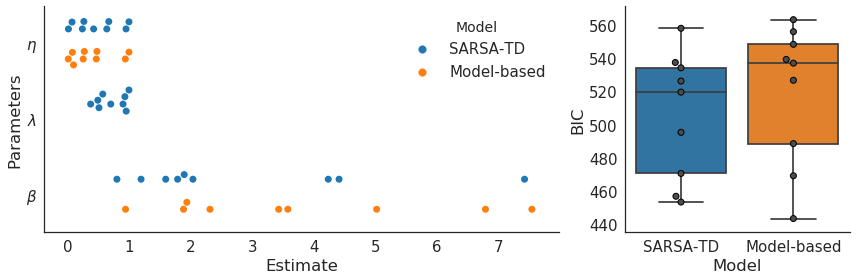

In [4]:
from tqdm import tqdm
from scipy.stats import ttest_rel

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define files / subjects.
files = sorted(os.listdir('data'))
subjects = [f.replace('.mat','') for f in files]

## Define model-fitting parameters.
n_starts = 5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize DataFrame.
fits = DataFrame([], columns=('Subject','Model','LogLik','Eta','Lambda','Beta','BIC'))

for i in tqdm(np.arange(len(files))):
    
    f, subj = files[i], subjects[i]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Load data.
    try: 
        mat = loadmat(os.path.join('data', f))
    except NotImplementedError:
        mat = h5py.File(os.path.join('data', f), 'r')
    
    ## Assemble choice data.
    Y = np.array([np.array(mat['choice1']).squeeze(), 
                  np.array(mat['choice2']).squeeze()]).T
    Y = Y.astype(int) - 1
    
    ## Assemble reward data.
    R = np.array(mat['money']).squeeze()

    ## Remove trials with missing data.
    indices = np.all(np.apply_along_axis(np.in1d, 0, Y, [0,1]), axis=-1)
    Y = Y[indices]
    R = R[indices]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### SARSA-TD learning model fitting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Find best fit of N.
    best_fit = np.inf
    for _ in np.arange(n_starts):
        
        ## Define initial parameters.
        x0 = np.random.normal(0,1,size=3)
        
        ## Minimize negative log-likelihood.
        fit = minimize(sarsa_ngl, x0, args=(Y,R), method='L-BFGS-B')
        if not fit.success: raise ValueError('Covergence not reached')
            
        ## Check if best fit.
        ngl = sarsa_ngl(fit.x, Y, R)
        if ngl < best_fit:
            best_fit = ngl
            eta, lambd, beta = fit.x            
        
    ## Compute BIC.
    k = 3
    BIC = np.log(R.size) * k + 2 * ngl
        
    ## Store values.
    row = Series([subj, 'SARSA-TD', -best_fit, eta, lambd, beta, BIC],
                 index=fits.columns)
    fits = fits.append(row, ignore_index=True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model-based TD learning model fitting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Find best fit of N.
    best_fit = np.inf
    for _ in np.arange(n_starts):
        
        ## Define initial parameters.
        x0 = np.random.normal(0,1,size=2)
        
        ## Minimize negative log-likelihood.
        fit = minimize(mb_ngl, x0, args=(Y,R), method='L-BFGS-B')
        if not fit.success: raise ValueError('Covergence not reached')
            
        ## Check if best fit.
        ngl = mb_ngl(fit.x, Y, R)
        if ngl < best_fit:
            best_fit = ngl
            eta, beta = fit.x            
        
    ## Compute BIC.
    k = 2
    BIC = np.log(R.size) * k + 2 * ngl
        
    ## Store values.
    row = Series([subj, 'Model-based', -best_fit, eta, np.nan, beta, BIC],
                 index=fits.columns)
    fits = fits.append(row, ignore_index=True)

## Convert parameters to appropriate scales.
fits[['Eta','Lambda','Beta']] = phi_approx(fits[['Eta','Lambda','Beta']])
fits['Beta'] *= 10

## Save.
fits.to_csv('fits.csv', index=False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,4))

## Print t-test.
t, p =  ttest_rel(fits.loc[fits.Model=='SARSA-TD','BIC'],
                  fits.loc[fits.Model=='Model-based','BIC'])
print('t = %0.3f, p = %0.3f' %(t,p))

## Split data by parameter.
params = fits[['Model','Eta','Lambda','Beta']].melt(id_vars='Model',
                                                    var_name='Parameter',
                                                    value_name='Estimate')

## Plot parameters.
ax = plt.subplot2grid((1,3),(0,0),colspan=2)
sns.swarmplot('Estimate', 'Parameter', 'Model', data=params,
               size=7, dodge=True, ax=ax)
ax.set_ylabel('Parameters')
ax.set_yticklabels([r'$\eta$', r'$\lambda$', r'$\beta$'])

## Plot BIC.
ax = plt.subplot2grid((1,3),(0,2))
sns.boxplot('Model', 'BIC', data=fits, ax=ax)
sns.swarmplot('Model', 'BIC', data=fits,  size=6, color='0.3',
              edgecolor='k', linewidth=1, ax=ax)

sns.despine()
plt.tight_layout()

Based on the best fits of nine datasets, there is slight evidence in favor of model-free SARSA-TD($\lambda$) learning as compared to model-based TD learning. This difference, however, is not significant.

## Part 4: Cliff Walking
Consider the grid world shown below. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked “The Cliff.” Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start.

<img src="cliffwalking.png" alt="Drawing" style="width: 525px;"/>

Two paths are marked: an optimal path which incurs the least costs on the way to the goal, and a roundabout (but safe) path that walks farthest from the cliff.

1) Which algorithm, SARSA or $Q$-learning, would learn either path, and why?

> SARSA would learn the safe path and $Q$-learning would learn the optimal path. $Q$-learning updates on the best possible action, regardless of what *actually* occurred (i.e. it is an off-policy learning rule). Thus, it would not update its expected values according to the worst possible outcome (i.e. falling off the cliff) but only the most optimal outcome (i.e. traversing along it). By contrast, SARSA is an on-policy learning rule and would update to reflect the severe penalty for falling off the cliff.

2) When behaving according to softmax of the learned $Q$-values, which path would an agent prefer? (Think about parameter $\beta$ and the stability of the environment.)

> When choosing a path according to the softmax of the learned $Q$-values, the chosen path will reflect the inverse temperature $\beta$. When $\beta$ is low and choice is relatively stochastic, then the safe path is preferable (i.e. put distance between the agent and cliff in case of randomly choosing the cliff). When $\beta$ is high and choice is relatively deterministic, then the optimal path is preferable since the probability of choosing a path off the cliff is low. 

> The chosen path will also reflect the environment. When the environment is unstable and transitions probabilistic, then the safe path is preferable (i.e. put distance between the agent and cliff in case of accidentally transitioning off the path and off the cliff). When the environment is stable and transitions deterministic, then the optimal path is preferable since the probability of transitioning off the cliff are low.

3) Can you suggest why on-policy methods might be superior for learning real-world motor behavior?

> In training motor actions, the goal is to specifically learn the value of particular motor sequences. This requires precise information about the value of each state-action pair learned from the action actually taken (on-policy), not the best possible action that might have been (off-policy). In other words, for motor learning we want precise value information for transitioning between state-action pairs.